In [1]:
import sys
sys.path.insert(0, '/home/emmanuel/code/kernellib')
sys.path.insert(0, '/home/emmanuel/code/py_esdc')
sys.path.insert(0, '/home/emmanuel/projects/2019_sakame/src/')

# from showprogress import showprogress
import xarray as xr
import numpy as np
import pandas as pd
import h5py

from data.make_dataset import ESDCData
from models.esdc_sampling import SamplingModel
from models.derivatives import GPRBFDerivative
from py_esdc.data import window_xy, get_xy_indices, get_3dgrid
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
%matplotlib inline

%load_ext autoreload
%autoreload 2

### Experiment Variables

In [2]:
# variables for the experiment
variables = [
    'gross_primary_productivity',
    'land_surface_temperature',
    'water_mask',
    'country_mask'
]

window_size = 5
start_time = '2010'
end_time = '2010'
subsection = 'europe'
data_path = '/media/disk/databases/BACI-CABLAB/low_res_data/'
minicube_path = '/home/emmanuel/projects/2019_sakame/data/processed/'

# Initialize data class

esdc_data = ESDCData(
    variables=variables,
    time_frame=[start_time, end_time],
    subsection=subsection
)

# extract data
data = esdc_data.extract_datacube()

/media/disk/databases/BACI-CABLAB/low_res_data/gross_primary_productivity


## Get MiniCubes

In [3]:
%%time

save_name = 'experiment_5.h5'

# Save Minicubes
dat = esdc_data.load_minicubes(save_name=save_name)

CPU times: user 372 ms, sys: 199 ms, total: 571 ms
Wall time: 2.02 s


In [4]:
time_stamps = [keys for keys in dat['gross_primary_productivity'].keys()]

### Training & Testing

In [5]:
x = dat['gross_primary_productivity']['2010-06-14T00:00:00.000000000']['x']
y = dat['gross_primary_productivity']['2010-06-14T00:00:00.000000000']['y']
lat = dat['gross_primary_productivity']['2010-06-14T00:00:00.000000000']['lat']
lon = dat['gross_primary_productivity']['2010-06-14T00:00:00.000000000']['lon']

xtrain, xtest, ytrain, ytest = train_test_split(x, y, train_size=500, random_state=123)

/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


## Train GP Model

In [6]:
%%time
sampling_model = SamplingModel()

sampling_model.train_model(xtrain, ytrain)

CPU times: user 1min 32s, sys: 313 ms, total: 1min 33s
Wall time: 12 s


In [7]:
%%time
# Testing
ypred = sampling_model.test_model(xtest)

CPU times: user 1.89 s, sys: 51 ms, total: 1.94 s
Wall time: 507 ms


In [8]:
%%time 

# sensitivity
sens_type = 'dim'
sens_summary = 'abs'

sens_dim = sampling_model.sensitivity(
    xtest,
    sens=sens_type,
    method=sens_summary
)

CPU times: user 12.1 s, sys: 76.8 ms, total: 12.1 s
Wall time: 5 s


### Train/Test Statistics

In [14]:
mae = mean_absolute_error(ytest, ypred)
mse = mean_squared_error(ytest, ypred)
r2 = r2_score(ytest, ypred)
rmse = np.sqrt(mse)
sens = np.mean(np.abs(sens_dim))

In [17]:
print(f'MAE: {mae:.4f}')
print(f'MSE: {mse:.4f}')
print(f'R2: {r2:.4f}')
print(f'RMSE: {rmse:.4f}')

print(f'Sensitivity: {sens}')
print(f'Sensitivity: {sens_dim.mean()}')

MAE: 0.3852
MSE: 0.2982
R2: 0.9491
RMSE: 0.5461
Sensitivity: 0.07193018479199872
Sensitivity: 0.07193018479199872


## Save Model

In [11]:
save_name = 'experiment_5.pckl'
print(sampling_model.model)
sampling_model.save_model(save_name)

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=RBF(length_scale=1) + WhiteKernel(noise_level=1),
             n_restarts_optimizer=1, normalize_y=True,
             optimizer='fmin_l_bfgs_b', random_state=None)


## Load Model

In [12]:
sampling_model.model = None
sampling_model.model

In [13]:
sampling_model.load_model(save_name)
sampling_model.model

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=RBF(length_scale=1) + WhiteKernel(noise_level=1),
             n_restarts_optimizer=1, normalize_y=True,
             optimizer='fmin_l_bfgs_b', random_state=None)

## Get Plot Data

In [18]:
# Data Points
variable = 'gross_primary_productivity'
time_stamp = '2010-06-14T00:00:00.000000000'
X = dat[variable][time_stamp]['x']
Y = dat[variable][time_stamp]['y']

# Get Predictions and Sensitivity
ypred = sampling_model.test_model(X)
sens_type = 'point'
sens_summary = 'abs'

sens = sampling_model.sensitivity(
    X,
    sens=sens_type,
    method=sens_summary
)

# Actual data points (Y)
y = dat[variable][time_stamp]['y']

# Coordinates
lat = dat[variable][time_stamp]['lat']
lon = dat[variable][time_stamp]['lon']



#### Convert to XArray

In [19]:
# ===========================
# Convert to XArray
# ===========================

# Extract original cube
esdc_data = ESDCData(
    variables=[variable],
    time_frame=[time_stamp, time_stamp],
    subsection=subsection
)

# extract data
plot_data = esdc_data.extract_datacube()

# Get original coordinates
xr_lon = plot_data.lon.values
xr_lat = plot_data.lat.values

# Create Raster Data
ypred = get_3dgrid(ypred, lat, lon, xr_lat, xr_lon)
sens = get_3dgrid(sens, lat, lon, xr_lat, xr_lon)
Y = get_3dgrid(Y, lat, lon, xr_lat, xr_lon)

/media/disk/databases/BACI-CABLAB/low_res_data/gross_primary_productivity


In [20]:
xr_results = xr.Dataset(
    data_vars={
        'labels': (['lat', 'lon', 'time', 'window'], Y[..., None, None]),
         'sensitivity': (['lat', 'lon', 'time', 'window'], sens[..., None, None]),
         'predictions': (['lat', 'lon', 'time', 'window'], ypred[..., None, None])},
     coords={
         'lon': xr_lon,
         'lat': xr_lat,
         'time': pd.date_range(time_stamp, periods=1),
         'window': [window_size]},
    attrs={
        'rmse': rmse,
        'mae': mae,
        'mse': mse,
        'r2': r2,
        'variable': variable
    }
)

# Add attributes to data
xr_results

<xarray.Dataset>
Dimensions:      (lat: 144, lon: 312, time: 1, window: 1)
Coordinates:
  * lon          (lon) float32 -17.875 -17.625 -17.375 ... 59.375 59.625 59.875
  * lat          (lat) float32 71.375 71.125 70.875 ... 36.125 35.875 35.625
  * time         (time) datetime64[ns] 2010-06-14
  * window       (window) int64 5
Data variables:
    labels       (lat, lon, time, window) float64 nan nan nan ... nan nan nan
    sensitivity  (lat, lon, time, window) float64 nan nan nan ... nan nan nan
    predictions  (lat, lon, time, window) float64 nan nan nan ... nan nan nan
Attributes:
    rmse:      0.5461073373756171
    mae:       0.38516333193101304
    mse:       0.29823322393548607
    r2:        0.9491065974310766
    variable:  gross_primary_productivity

<xarray.DataArray 'labels' (lat: 144, lon: 312)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * lon      (lon) float32 -17.875 -17.625 -17.375 ... 59.375 59.625 59.875
  * lat      (lat) float32 71.375 71.125 70.875 70.625 ... 36.125 35.875 35.625
    time     datetime64[ns] 2010-06-14
    window   int64 5


/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/matplotlib/tight_layout.py:176: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  warnings.warn('Tight layout not applied. The left and right margins '


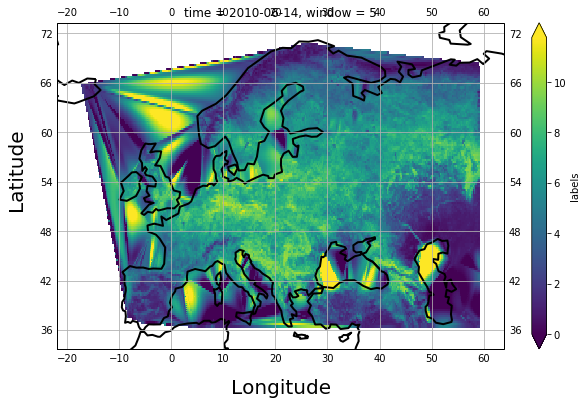

In [21]:
# select data subset
subset = xr_results.labels.isel(window=0).isel(time=0)

print(subset)
fig = plt.figure(figsize=(10, 6))

ax = fig.add_subplot(111, projection=ccrs.PlateCarree(), aspect='auto')


p = subset.plot.pcolormesh(
    ax=ax, transform=ccrs.PlateCarree(),
    robust=True, cmap='viridis', vmin=0,
#         cbar_kwargs={'label': subset.gross_primary_productivity.units, 
#                      'format': '%.1f'}
)
# cbar = fig.colorbar(p)
ax.coastlines(linewidth=2)
ax.gridlines(draw_labels=True)
ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor', fontsize=20,
        transform=ax.transAxes)
ax.text(0.5, -0.15, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor', fontsize=20,
        transform=ax.transAxes)
plt.tight_layout()
# save_plt_name = f'{variable}_labels_mean_before_{window_size}'
# plt.savefig(figures_path + save_plt_name + '.png')
plt.show()

#### Masks

In [24]:
# Extract original cube
esdc_data = ESDCData(
    variables=['water_mask'],
    time_frame=['2001', '2001'],
    subsection='europe'
)

# Water Mask
mask_data = esdc_data.extract_datacube().isel(time=0).water_mask

# Add Mask
xr_results.coords['mask'] = (('lat', 'lon'), mask_data)

/media/disk/databases/BACI-CABLAB/low_res_data/water_mask


<xarray.DataArray (lat: 144, lon: 312)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * lon      (lon) float32 -17.875 -17.625 -17.375 ... 59.375 59.625 59.875
  * lat      (lat) float32 71.375 71.125 70.875 70.625 ... 36.125 35.875 35.625
    time     datetime64[ns] 2010-06-14
    window   int64 5
    mask     (lat, lon) float32 2.0 2.0 2.0 2.0 2.0 2.0 ... 1.0 1.0 1.0 1.0 1.0


/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/matplotlib/tight_layout.py:176: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  warnings.warn('Tight layout not applied. The left and right margins '


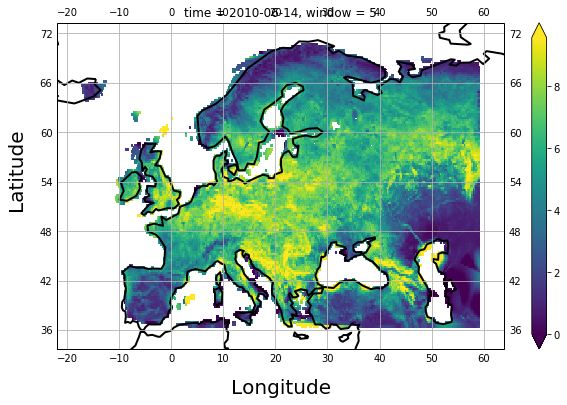

In [25]:

# select data subset
subset = xr_results.labels.isel(window=0).isel(time=0).where(xr_results.mask == 1)

print(subset)
fig = plt.figure(figsize=(10, 6))

ax = fig.add_subplot(111, projection=ccrs.PlateCarree(), aspect='auto')


p = subset.plot.pcolormesh(
    ax=ax, transform=ccrs.PlateCarree(),
    robust=True, cmap='viridis', vmin=0,
#         cbar_kwargs={'label': subset.gross_primary_productivity.units, 
#                      'format': '%.1f'}
)
# cbar = fig.colorbar(p)
ax.coastlines(linewidth=2)
ax.gridlines(draw_labels=True)
ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor', fontsize=20,
        transform=ax.transAxes)
ax.text(0.5, -0.15, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor', fontsize=20,
        transform=ax.transAxes)
plt.tight_layout()
# save_plt_name = f'{variable}_labels_mean_before_{window_size}'
# plt.savefig(figures_path + save_plt_name + '.png')
plt.show()

### Save Results

In [18]:
save_path = '/home/emmanuel/projects/2019_sakame/data/results/'
save_name = f"experiment_{variable}.nc"
xr_results.to_netcdf(save_path + save_name)

### Load Results

In [19]:
with xr.open_dataset(save_path + save_name) as xr_results:
    print(xr_results)

<xarray.Dataset>
Dimensions:      (lat: 144, lon: 312, time: 1, window: 1)
Coordinates:
  * lon          (lon) float32 -17.875 -17.625 -17.375 ... 59.375 59.625 59.875
  * lat          (lat) float32 71.375 71.125 70.875 ... 36.125 35.875 35.625
  * time         (time) datetime64[ns] 2010-06-14
  * window       (window) int64 5
    mask         (lat, lon) float32 ...
Data variables:
    labels       (lat, lon, time, window) float64 ...
    sensitivity  (lat, lon, time, window) float64 ...
    predictions  (lat, lon, time, window) float64 ...
Attributes:
    rmse:      0.5461073373756171
    mae:       0.38516333193101304
    mse:       0.29823322393548607
    r2:        0.9491065974310766
    variable:  gross_primary_productivity


## Experiment

In [29]:
window_sizes = [3, 5, 7, 9, 11, 15]
variables = [
    'gross_primary_productivity',
    'land_surface_temperature'
]
minicube_path = '/home/emmanuel/projects/2019_sakame/data/processed/nb_data/'

for ivariable in variables:
    for iwindow in window_sizes:


        # Initialize data class

        esdc_data = ESDCData(
            minicube_path=minicube_path,
            variables=[str(ivariable)],
            time_frame=[start_time, end_time],
            subsection=subsection,
        
        )

        # extract data
        data = esdc_data.extract_datacube()
        
        # load minicubes
        save_name = f'nbexp_{iwindow}_{ivariable}.h5'
        dat = esdc_data.load_minicubes(save_name=save_name)
        
        # Get Time Stamps
        time_stamps = [keys for keys in dat[ivariable].keys()]
        break
        
    break

/media/disk/databases/BACI-CABLAB/low_res_data/gross_primary_productivity
